# Viral Tweets Prediction Challenge
Develop a machine learning model to predict the virality level of each tweet based on attributes such as tweet content, media attached to the tweet, and date/time published.

In this notebook:
- Data processing: one-hot encoding + cyclical encoding for categorical features. Normalization.
- LASSO regression for feature selection
- Memory footprint reduction of data
- Hyperparmeter tuning with RandomizedSearchCV
- Building LightGBM classifier model for prediction
- Feature importance visualization

## Environment details 
**OS:** macOS Big Sur 11.4  
**Memory:** 16 GB 2133 MHz LPDDR3  
**Disk Space:** 1 TB Flask Stroage  
**CPU/GPU:** Intel HD Graphics 530 1536 MB  

### Which data files are being used?
- train_tweets.csv
- train_tweets_vectorized_media.csv
- train_tweets_vectorized_text.csv
- users.csv
- user_vectorized_descriptions.csv
- user_vectorized_profile_images.csv
- test_tweets.csv
- test_tweets_vectorized_media.csv
- test_tweets_vectorized_text.csv

### How are these files processed?
- Filling missing topic_ids with ['0']
- One hot encoding for categorical variables
- Cyclical encoding for hour

### What is the algorithm used and what are its main hyperparameters?
Used Lightgbm Classifier:  
``` LGBMClassifier(colsample_bytree=0.7076074093370144, min_child_samples=105,
               min_child_weight=1e-05, num_leaves=26, reg_alpha=5, reg_lambda=5,
               subsample=0.7468773130235173) ```

# Import libraries

In [4]:
#!pip install lightgbm

In [5]:
import pandas as pd
import numpy as np
import timeit
import collections
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Preprocessing + Feature Selection
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

# Model Building
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# Hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Metrics
from sklearn.metrics import accuracy_score

In [6]:
# Function takes the minimum and the maximum of each column and changes the data type to what is optimal for the column.
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Data retrieval

In [8]:
# Kagge storage path
path = "data/"

# Training datasets
train_tweets = pd.read_csv(path + 'Tweets/train_tweets.csv')
train_tweets_vectorized_media = pd.read_csv(path + 'Tweets/train_tweets_vectorized_media.csv')
train_tweets_vectorized_text = pd.read_csv(path + 'Tweets/train_tweets_vectorized_text.csv')

# Test dataset
test_tweets = pd.read_csv(path + 'Tweets/test_tweets.csv')
test_tweets_vectorized_media = pd.read_csv(path + 'Tweets/test_tweets_vectorized_media.csv')
test_tweets_vectorized_text = pd.read_csv(path + 'Tweets/test_tweets_vectorized_text.csv')

# User dataset
users = pd.read_csv(path + 'Users/users.csv')
user_vectorized_descriptions = pd.read_csv(path + 'Users/user_vectorized_descriptions.csv')
user_vectorized_profile_images = pd.read_csv(path + 'Users/user_vectorized_profile_images.csv')

# Solutions format
solutions_format = pd.read_csv(path + "solution_format.csv")

# Dimensions of Data

In [9]:
# print dimensions of data
print('Dimensions:')
print('Train tweets:', train_tweets.shape)
print('Train tweets vectorized media:', train_tweets_vectorized_media.shape)
print('Train tweets vectorized text:', train_tweets_vectorized_text.shape)
print()

print('Test tweets:', test_tweets.shape)
print('Test tweets vectorized media:', test_tweets_vectorized_media.shape)
print('Test tweets vectorized text:', test_tweets_vectorized_text.shape)
print()

print('Users:', users.shape)
print('User vectorized descriptions:', user_vectorized_descriptions.shape)
print('User vectorized profile images:', user_vectorized_profile_images.shape)

Dimensions:
Train tweets: (29625, 14)
Train tweets vectorized media: (21010, 2050)
Train tweets vectorized text: (29625, 769)

Test tweets: (12697, 13)
Test tweets vectorized media: (8946, 2050)
Test tweets vectorized text: (12697, 769)

Users: (52, 11)
User vectorized descriptions: (52, 769)
User vectorized profile images: (52, 2049)


The dimensions for ```Users``` are smaller than ```Tweets```, which indicate that the users in the dataset may have multiple tweets.    
Vectorized text has the same number of rows as tweets, meaning that all tweets have text.  
Vectorized media has fewer rows than tweets, indicating that not all tweets have media or that some tweets have multiple media.  
All ```Users``` have descriptions and profile images.

# Exploratory Data Analysis
## Train Tweets

In [10]:
train_tweets.head()

,tweet_id,tweet_user_id,tweet_created_at_year,tweet_created_at_month,tweet_created_at_day,tweet_created_at_hour,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,tweet_attachment_class,tweet_language_id,tweet_topic_ids,virality
0,34698,10,2015,12,5,3,2.0,1.0,0.0,False,C,0,"['36', '36', '36', '36', '36', '36', '37', '37...",3
1,24644,4,2020,6,19,0,0.0,1.0,0.0,False,C,0,"['43', '78', '79', '80', '80', '89', '98', '99...",3
2,36321,54,2019,6,2,15,2.0,3.0,0.0,True,A,0,"['79', '80', '98', '98', '98', '99', '99', '10...",1
3,2629,42,2020,9,6,17,0.0,1.0,1.0,True,A,0,"['43', '79', '80', '98', '99', '99', '79', '80']",2
4,28169,32,2020,11,4,17,2.0,1.0,0.0,True,A,0,"['79', '80', '98', '99', '43', '89']",2


Primary Keys: ```tweet_id```, ```tweet_user_id```. There are 11 Features. Target variable: ```virality```. Tweet data are connected thorugh ```tweet_id```.

In [11]:
train_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                29625 non-null  int64  
 1   tweet_user_id           29625 non-null  int64  
 2   tweet_created_at_year   29625 non-null  int64  
 3   tweet_created_at_month  29625 non-null  int64  
 4   tweet_created_at_day    29625 non-null  int64  
 5   tweet_created_at_hour   29625 non-null  int64  
 6   tweet_hashtag_count     29625 non-null  float64
 7   tweet_url_count         29625 non-null  float64
 8   tweet_mention_count     29625 non-null  float64
 9   tweet_has_attachment    29625 non-null  bool   
 10  tweet_attachment_class  29625 non-null  object 
 11  tweet_language_id       29625 non-null  int64  
 12  tweet_topic_ids         25340 non-null  object 
 13  virality                29625 non-null  int64  
dtypes: bool(1), float64(3), int64(8), obje

### Tweet Creation Date
tweet_created_at_year  
tweet_created_at_day  
tweet_created_at_month  
tweet_created_at_hour

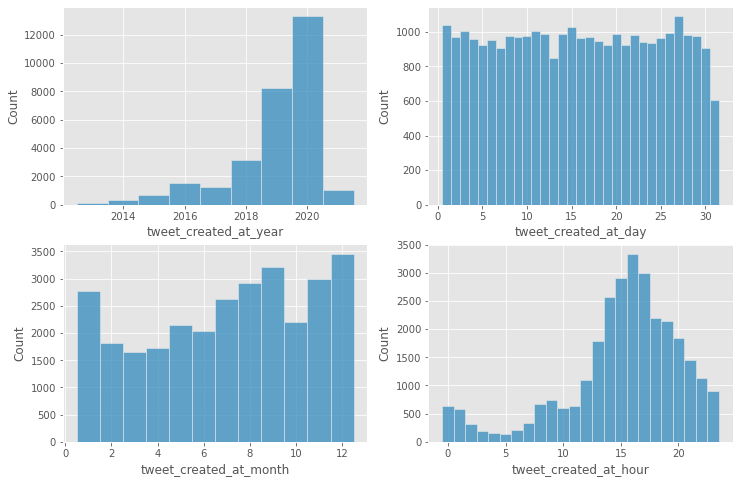

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(train_tweets, x = 'tweet_created_at_year', discrete = True, ax = axs[0,0])
sns.histplot(train_tweets, x = 'tweet_created_at_day', discrete = True, ax = axs[0,1])
sns.histplot(train_tweets, x = 'tweet_created_at_month', discrete = True, ax = axs[1,0])
sns.histplot(train_tweets, x = 'tweet_created_at_hour', discrete = True, ax = axs[1,1])
plt.show()

- The histplot for ```tweet_created_at_year``` shows a left skeweed distribution between 2013-2020 where each subsequent year has more tweets created. Note that this data was produced during 2021, so the count for ```tweet_created_at_year``` for 2021 does not account for the full year unlike others.
- The histplot for ```tweet_created_at_month``` show that December is the month with the highest number of tweets created. The lowest being March.
- The histplot for ```tweet_created_at_day``` generally has a uniform distribution. The highest being 27th, perhaps because February have 28 days. The 31st is an outlier because not all months have 31 days. 
- The histplot for ```tweet_created_at_hour``` show a cyclical distribution where most tweets are created during the afternoon/evening, the highest being 4pm. The least amount where created late at night/early in the morning.

### Tweet Message Content
tweet_hashtag_count  
tweet_url_count  
tweet_mention_count

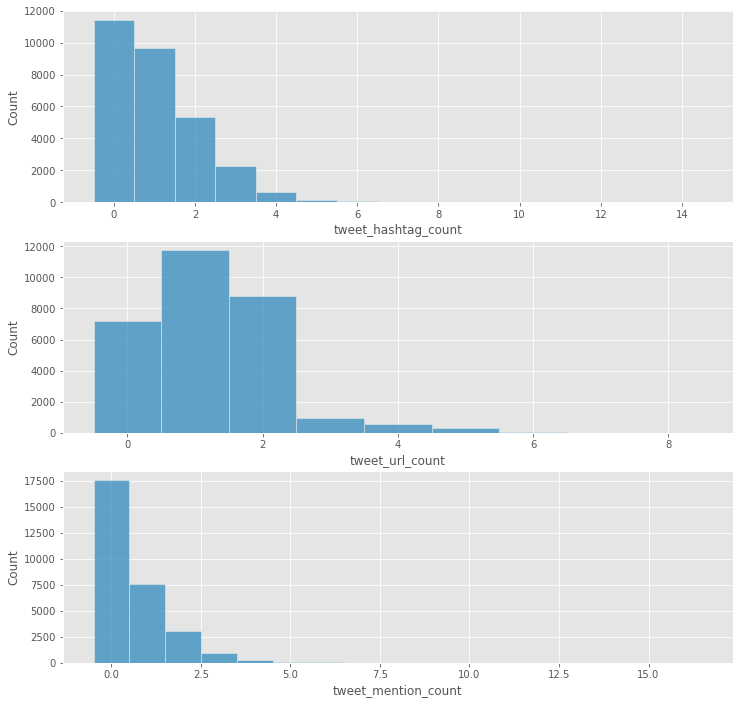

In [13]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
sns.histplot(x = 'tweet_hashtag_count', data = train_tweets, discrete = True, ax = axs[0])
sns.histplot(x = 'tweet_url_count', data = train_tweets, discrete = True, ax = axs[1])
sns.histplot(x = 'tweet_mention_count', data = train_tweets, discrete = True, ax = axs[2])
plt.show()

- The histplot for ```tweet_hashtag_count``` is right skewed where most tweets have zero hashtags and less tweets have more hashtags.
- The histplot for ```tweet_url_count``` shows that most tweets have one URL, and not many tweets have a high number of tweets.
- The histplot for ```tweet_mention_count``` is right skewed where most tweets have zero mentions and less tweets have multiple hashtags.

### Tweet Attatchment
tweet_has_attachment   
tweet_attachment_class

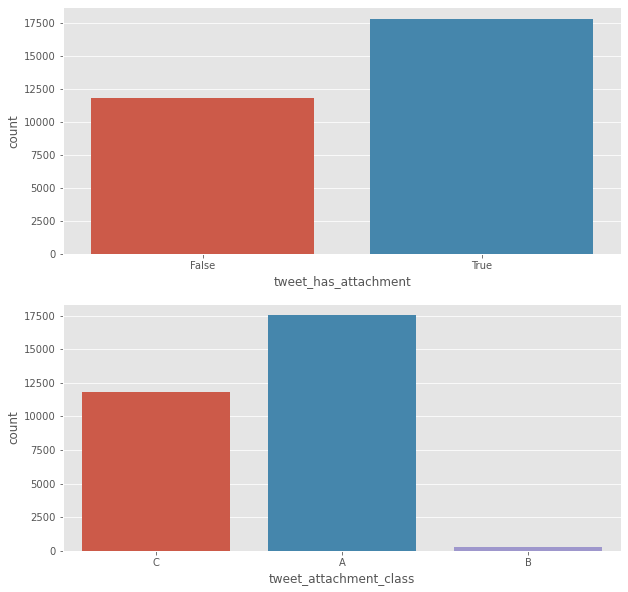

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
sns.countplot(x = 'tweet_has_attachment', data = train_tweets, ax = axs[0])
sns.countplot(x = 'tweet_attachment_class', data = train_tweets, ax = axs[1])
plt.show()

- The countplot for ```tweet_has_attachment``` shows that more tweets have an attachment, such as media.
- The countplot for ```tweet_attachment_class``` shows that most tweets have an attachment class A, and very few tweets have attachment class B.

### Tweet Language

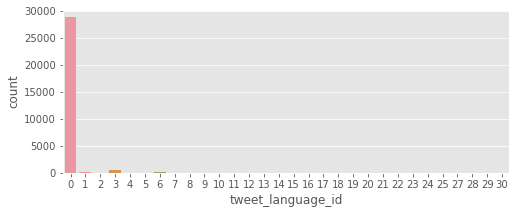

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(8, 3))
sns.countplot(x = 'tweet_language_id', data = train_tweets, ax = axs)
plt.show()

- The countplot for ```tweet_language_id``` shows a high amount of tweets in language_id 0, which is presumed to be english. Very few tweets in this datset are in other languages.

### Tweet Virality

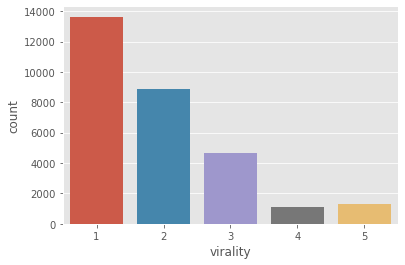

In [16]:
sns.countplot(x = 'virality', data = train_tweets)
plt.show()

- The countplot for ```virality``` shows the virality of tweets where 1 is low whereas 5 is high. Most tweets have a virality of 1.

Since there are 5 values in ```virality```, this means that this is a multi-class classification problem.

### Correlation Matrix

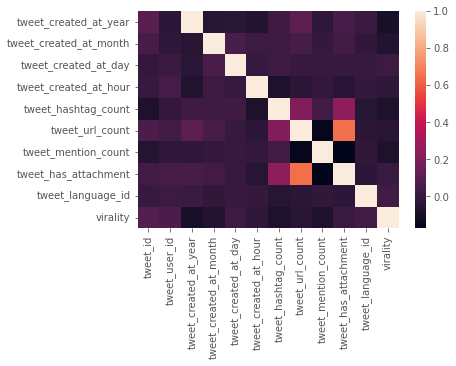

In [17]:
corrmat = train_tweets.corr()[2:] 
sns.heatmap(corrmat, square=True);

The heatmap shows that some features have correlation with each other. ```tweet_url_count``` and ```tweet_has_attachment``` has the highest correlation with each other.

In [18]:
df_corr = train_tweets.corr()['virality'][2:-1]
top_features = df_corr.sort_values(ascending=False, key=abs)
top_features

tweet_created_at_year    -0.096487
tweet_hashtag_count      -0.083262
tweet_mention_count      -0.081958
tweet_created_at_month   -0.063757
tweet_url_count          -0.047833
tweet_language_id         0.030416
tweet_created_at_hour    -0.028583
tweet_created_at_day      0.017518
tweet_has_attachment      0.005401
Name: virality, dtype: float64

The correlation numbers show a low correlation between virality and features, meaning they cannot be used linearly to predict virality.

## Train Tweets Vecotrized Media

In [19]:
train_tweets_vectorized_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21010 entries, 0 to 21009
Columns: 2050 entries, media_id to img_feature_2047
dtypes: float64(2048), int64(1), object(1)
memory usage: 328.6+ MB


Primary Keys: ```media_id```, ```tweet_id```. There are 2048 Features. Tweet data are connected thorugh ```tweet_id```.

## Train Tweets Vectorized Text

In [20]:
train_tweets_vectorized_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29625 entries, 0 to 29624
Columns: 769 entries, tweet_id to feature_767
dtypes: float64(768), int64(1)
memory usage: 173.8 MB


Primary Keys: ```tweet_id```. There are 768 Features. Tweet data are connected thorugh ```tweet_id```.

Each column in Vectorized Text/Media represents one coordinate in the numeric feature space

## Users

In [21]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   user_id                52 non-null     int64
 1   user_like_count        52 non-null     int64
 2   user_followers_count   52 non-null     int64
 3   user_following_count   52 non-null     int64
 4   user_listed_on_count   52 non-null     int64
 5   user_has_location      52 non-null     bool 
 6   user_tweet_count       52 non-null     int64
 7   user_has_url           52 non-null     bool 
 8   user_verified          52 non-null     int64
 9   user_created_at_year   52 non-null     int64
 10  user_created_at_month  52 non-null     int64
dtypes: bool(2), int64(9)
memory usage: 3.9 KB


Primary Keys: ```user_id```. There are 10 Features. User data are connected thorugh ```user_id```.

### User Count
user_like_count  
user_followers_count  
user_following_count  
user_listed_on_count  
user_tweet_count

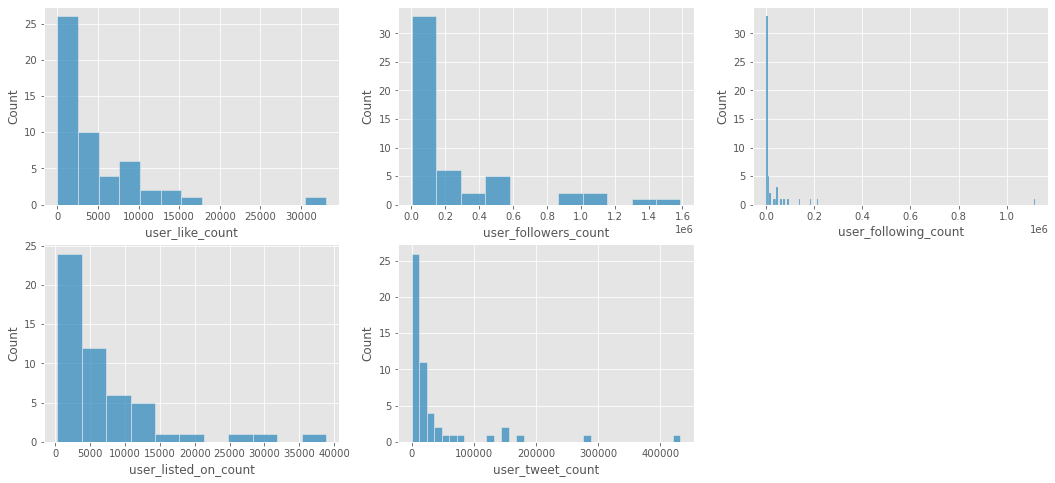

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
sns.histplot(users, x = 'user_like_count', ax = axs[0,0])
sns.histplot(users, x = 'user_followers_count', ax = axs[0,1])
sns.histplot(users, x = 'user_following_count', ax = axs[0,2])
sns.histplot(users, x = 'user_listed_on_count', ax = axs[1,0])
sns.histplot(users, x = 'user_tweet_count', ax = axs[1,1])
axs[1][2].set_visible(False)
plt.show()

- The histplot for ```user_like_count``` is right skewed. A large propotion of users have between 0-2500 likes.
- The histplot for ```user_follower_count``` is right skewed. A large propotion of users have between 0-10000 followers.
- The histplot for ```user_following_count``` is right skewed. A large propotion of users follow between 0-1000 accounts.
- The histplot for ```user_listed_on_count``` is right skewed. A large propotion of users are listed on between 0-5000 lists.
- The histplot for ```user_tweet_count``` is right skewed. A large propotion of users have between 0-10000 tweeets.

### User Creation Date

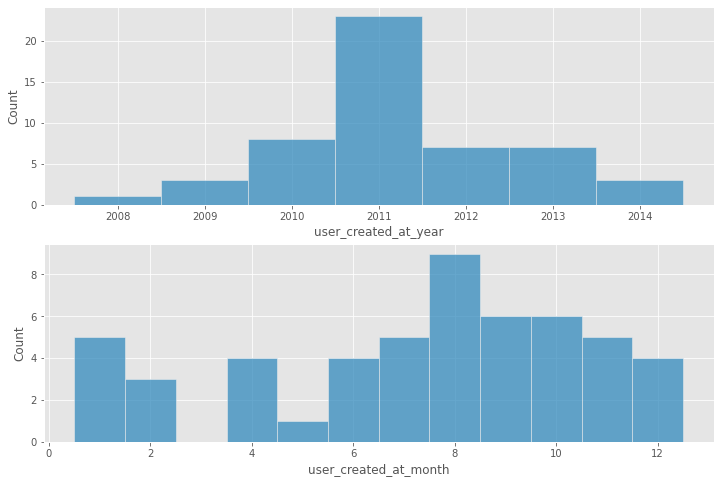

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
sns.histplot(users, x = 'user_created_at_year', discrete = True, ax = axs[0])
sns.histplot(users, x = 'user_created_at_month', discrete = True, ax = axs[1])
plt.show()

- The histplot for ```user_created_at_year``` shows that most users were created in 2011.
- The histplot for ```user_created_at_month``` shows that most users were created in August. 0 users were creaed in March, which may explain why March has the lowest tweets created.

### User Has
user_has_location  
user_has_url  
user_verified

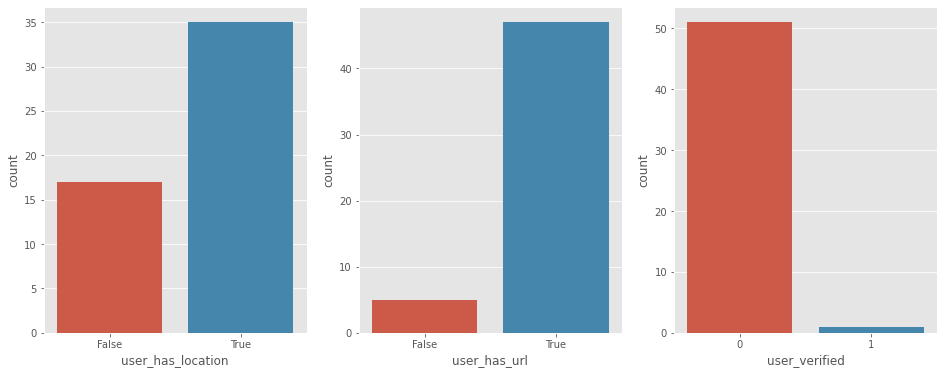

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(x = 'user_has_location', data = users, ax = axs[0])
sns.countplot(x = 'user_has_url', data = users, ax = axs[1])
sns.countplot(x = 'user_verified', data = users, ax = axs[2])
plt.show()

For the binary data: most of the users have their location and url listed on their accounts. Most of them are not verified.

## User Vectorized Descriptions

In [25]:
user_vectorized_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 769 entries, user_id to feature_767
dtypes: float64(768), int64(1)
memory usage: 312.5 KB


Primary Keys: ```user_id```. There are 768 Features. User data are connected thorugh ```user_id```.

Vectorized descriptions and vectorized text have the same number of features.

## User Vectorized Profile Images

In [26]:
user_vectorized_profile_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 2049 entries, user_id to feature_2047
dtypes: float64(2048), int64(1)
memory usage: 832.5 KB


Primary Keys: ```user_id```. There are 2048 Features. User data are connected thorugh ```user_id```.

Vectorized media and vectorized profile images have the same number of features.

# Data Preprocessing & Wrangling

In [27]:
train_tweets.isnull().sum()

tweet_id                     0
tweet_user_id                0
tweet_created_at_year        0
tweet_created_at_month       0
tweet_created_at_day         0
tweet_created_at_hour        0
tweet_hashtag_count          0
tweet_url_count              0
tweet_mention_count          0
tweet_has_attachment         0
tweet_attachment_class       0
tweet_language_id            0
tweet_topic_ids           4285
virality                     0
dtype: int64

Only ```tweet_topic_ids``` have null values. These will treated as another tweet_topic_id by filling them with another id such as ```["0"]```. (The number does not matter as long as it is distinct from other values).

In [28]:
train_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

The rest of the data files do not have non-null values.

## Categorical Variables
### Train Tweets
#### One-hot encoding

In [29]:
# Split topic ids
topic_ids = (
    train_tweets.tweet_topic_ids.str.strip('[]').str.split('\s*,\s*').explode().str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [30]:
year = pd.get_dummies(train_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(train_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(train_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(train_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(train_tweets.tweet_language_id, prefix='language')

#### Cyclical Encoding
From histplot we saw that hours have a cyclical distribution so we will us cyclical encoding.

In [31]:
hour_sin = np.sin(2 * np.pi * train_tweets['tweet_created_at_hour']/24.0)
hour_sin.name = 'hour_sin'
hour_cos = np.cos(2 * np.pi * train_tweets['tweet_created_at_hour']/24.0)
hour_cos.name = 'hour_cos'

In [32]:
# Join encoded data to train data.
columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
               ]
encoded = [topic_ids, year, month, day, attachment, language, hour_sin, hour_cos]

train_tweets_final = train_tweets.drop(columns_drop, 1).join(encoded)
train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,topic_id_0,topic_id_100,topic_id_101,...,language_22,language_23,language_24,language_25,language_27,language_28,language_29,language_30,hour_sin,hour_cos
0,34698,10,2.0,1.0,0.0,False,3,0,0,0,...,0,0,0,0,0,0,0,0,0.707107,0.707107
1,24644,4,0.0,1.0,0.0,False,3,0,1,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2,36321,54,2.0,3.0,0.0,True,1,0,2,0,...,0,0,0,0,0,0,0,0,-0.707107,-0.707107
3,2629,42,0.0,1.0,1.0,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.965926,-0.258819
4,28169,32,2.0,1.0,0.0,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.965926,-0.258819


### Users
#### One-hot encoding

In [33]:
year = pd.get_dummies(users.user_created_at_year, prefix='year')
month = pd.get_dummies(users.user_created_at_month , prefix='month')

In [34]:
# Join encoded data to train data.
columns_drop = [
                "user_created_at_year",
                "user_created_at_month",
               ]
dfs = [year, month]

users_final = users.drop(columns_drop, 1).join(dfs)
users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,year_2008,...,month_2,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1164,48720,70469,5956,True,14122,True,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,3914,85361,2171,5943,False,6957,False,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,8292,200944,1416,8379,True,83485,True,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,1770,15385,4572,1866,True,12265,True,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,15311,459083,1021,7368,False,121193,False,0,0,...,0,0,0,1,0,0,0,0,0,0


## Normalize Data
Machine learning algorithms perform better or converage faster when the features are on a small scale. Let's normalize the counts.
### Train Tweets

In [35]:
# Normalize using reprocessing.normalize
scaled_tweet_hashtag_count = preprocessing.normalize([train_tweets_final["tweet_hashtag_count"]])
train_tweets_final["tweet_hashtag_count"] = scaled_tweet_hashtag_count[0]

scaled_tweet_url_count = preprocessing.normalize([train_tweets_final["tweet_url_count"]])
train_tweets_final["tweet_url_count"] = scaled_tweet_url_count[0]

scaled_tweet_mention_count = preprocessing.normalize([train_tweets_final["tweet_mention_count"]])
train_tweets_final["tweet_mention_count"] = scaled_tweet_mention_count[0]
train_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,virality,topic_id_0,topic_id_100,topic_id_101,...,language_22,language_23,language_24,language_25,language_27,language_28,language_29,language_30,hour_sin,hour_cos
0,34698,10,0.007533,0.003707,0.000000,False,3,0,0,0,...,0,0,0,0,0,0,0,0,0.707107,0.707107
1,24644,4,0.000000,0.003707,0.000000,False,3,0,1,0,...,0,0,0,0,0,0,0,0,0.000000,1.000000
2,36321,54,0.007533,0.011122,0.000000,True,1,0,2,0,...,0,0,0,0,0,0,0,0,-0.707107,-0.707107
3,2629,42,0.000000,0.003707,0.004852,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.965926,-0.258819
4,28169,32,0.007533,0.003707,0.000000,True,2,0,0,0,...,0,0,0,0,0,0,0,0,-0.965926,-0.258819


### User

In [36]:
users_final["user_like_count"] = preprocessing.normalize([users_final["user_like_count"]])[0]
users_final["user_followers_count"] = preprocessing.normalize([users_final["user_followers_count"]])[0]
users_final["user_following_count"] = preprocessing.normalize([users_final["user_following_count"]])[0]
users_final["user_listed_on_count"] = preprocessing.normalize([users_final["user_listed_on_count"]])[0]
users_final["user_tweet_count"] = preprocessing.normalize([users_final["user_tweet_count"]])[0]
users_final.head()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,year_2008,...,month_2,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,0.021992,0.015328,0.060170,0.079637,True,0.022790,True,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0.073949,0.026856,0.001854,0.079463,False,0.011227,False,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,0.156666,0.063220,0.001209,0.112034,True,0.134730,True,0,0,...,0,0,0,1,0,0,0,0,0,0
3,3,0.033442,0.004840,0.003904,0.024950,True,0.019793,True,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,0.289280,0.144435,0.000872,0.098516,False,0.195583,False,0,0,...,0,0,0,1,0,0,0,0,0,0


# Feature Selection
Fit a LASSO regression on our dataset and only consider features that have a conefficient different from 0. This reduce the number of features and helps the model generalize better for future datasets.
## Train Tweets Media

In [37]:
print("train_tweets shape:", train_tweets.shape)
print("train_tweets_vectorized_media shape:", train_tweets_vectorized_media.shape)

# Match row number between train tweets and vectorized media
vectorized_media_df = pd.merge(train_tweets, train_tweets_vectorized_media, on='tweet_id', how='right')
# Drop extra columns
vectorized_media_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_media_df.head()

train_tweets shape: (29625, 14)
train_tweets_vectorized_media shape: (21010, 2050)


,virality,media_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,1,00001_00000,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,2,00004_00003,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,1,00005_00004,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,1,00008_00007,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,1,00009_00008,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


In [38]:
# Set the target as well as dependent variables from image data.
y = vectorized_media_df['virality']
x = vectorized_media_df.loc[:, vectorized_media_df.columns.str.contains("img_")] 

# Run Lasso regression for feature selection.
sel_model = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  128.135930375


Counter({True: 2046, False: 2})

In [39]:
media_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_media_final = pd.concat([train_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
train_tweets_media_final.head()

,media_id,tweet_id,img_feature_0,img_feature_1,img_feature_2,img_feature_3,img_feature_4,img_feature_5,img_feature_6,img_feature_7,...,img_feature_2038,img_feature_2039,img_feature_2040,img_feature_2041,img_feature_2042,img_feature_2043,img_feature_2044,img_feature_2045,img_feature_2046,img_feature_2047
0,00001_00000,1,0.290614,0.150803,0.008313,0.040887,0.0,0.000000,0.214209,0.000792,...,0.000000,0.249240,0.040368,0.101314,0.000000,0.069272,0.167507,0.044617,0.383093,0.097627
1,00004_00003,4,0.038251,0.036437,0.000000,0.015076,0.0,0.046953,0.648170,0.026476,...,0.024564,0.035555,0.369353,0.000000,0.133307,0.000000,0.000000,0.017894,0.816972,0.058774
2,00005_00004,5,0.506981,0.305467,0.036150,0.114539,0.0,0.146888,0.584753,0.157468,...,0.000000,0.131493,0.268107,0.000000,0.036761,0.008600,0.018883,0.024825,0.123289,0.000000
3,00008_00007,8,0.000000,0.242857,0.000000,0.068217,0.0,0.117847,0.000000,0.000000,...,0.095629,0.221957,0.133745,0.023491,0.000000,0.000000,0.000000,0.065544,1.030737,0.010370
4,00009_00008,9,0.000000,0.141986,0.000000,0.000983,0.0,0.013148,0.066999,0.008579,...,0.000000,0.480097,0.361314,0.026121,0.000000,0.000000,0.000000,0.001085,0.653569,0.007591


## Train Tweets Text

In [40]:
print("train_tweets shape:", train_tweets.shape)
print("train_tweets_vectorized_text:", train_tweets_vectorized_media.shape)

# Match row number between train tweets and vectorized text
vectorized_text_df = pd.merge(train_tweets, train_tweets_vectorized_text, on='tweet_id', how='right')
# Drop extra columns
vectorized_text_df.drop(train_tweets.columns.difference(['virality']), axis=1, inplace=True)
vectorized_text_df.head()

train_tweets shape: (29625, 14)
train_tweets_vectorized_text: (21010, 2050)


,virality,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,2,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,1,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,1,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [41]:
# Set the target as well as dependent variables from image data.
y = vectorized_text_df['virality']
x = vectorized_text_df.loc[:, train_tweets_vectorized_text.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  393.13100087399994


Counter({True: 670, False: 98})

In [42]:
text_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
train_tweets_text_final = pd.concat([train_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)
train_tweets_text_final.head()

,tweet_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


## User Descriptions

In [43]:
# Find the median virality for each user to reduce features
average_virality_df = train_tweets.groupby('tweet_user_id').agg(pd.Series.median)['virality']

Obtain median of virality since each user may have multiple tweets.

In [44]:
descriptions_df = pd.merge(average_virality_df, user_vectorized_descriptions, left_on='tweet_user_id', right_on='user_id', how='right')
descriptions_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,1.0,0,0.132536,-0.137393,-0.064037,-0.118342,-0.130279,0.048067,-0.421301,-0.313038,...,0.238264,-0.315408,-0.159851,-0.003840,0.213492,0.002498,0.177574,-0.136515,-0.012882,0.017399
1,2.0,1,0.107849,-0.168418,0.027251,-0.075079,-0.084762,0.076149,-0.390708,-0.271934,...,0.232922,-0.314534,-0.177011,-0.041710,0.209785,-0.023427,0.158203,-0.143221,0.030484,0.081693
2,1.0,2,0.122312,-0.159376,-0.073417,-0.149442,-0.122684,-0.005277,-0.351233,-0.297342,...,0.173621,-0.292476,-0.185078,-0.026784,0.184902,0.009539,0.217004,-0.091951,0.025304,0.058501
3,1.0,3,0.160509,-0.137915,-0.002524,-0.034696,0.028126,0.056299,-0.365196,-0.259523,...,0.205752,-0.300688,-0.133753,0.002206,0.245214,-0.056659,0.152064,-0.180211,0.022327,0.014688
4,3.0,4,0.099192,-0.140809,-0.012423,-0.150097,-0.120169,0.054078,-0.384291,-0.269650,...,0.179307,-0.367725,-0.217667,-0.064391,0.163382,-0.020638,0.181554,-0.200262,-0.074513,0.037301


In [45]:
# Set the target as well as dependent variables from image data.
y = descriptions_df['virality']
x = descriptions_df.loc[:, descriptions_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.010133559999985664


Counter({False: 768})

In [46]:
desc_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_descriptions_final = pd.concat([user_vectorized_descriptions[['user_id']], desc_ind_df], axis=1)
user_descriptions_final.head()

,user_id
0,0
1,1
2,2
3,3
4,4


## User Profile Images

In [47]:
profile_images_df = pd.merge(average_virality_df, user_vectorized_profile_images, left_on='tweet_user_id', right_on='user_id', how='right')
profile_images_df.head()

,virality,user_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_2038,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047
0,1.0,0,0.449126,0.000000,0.000000,0.0,0.006348,0.000000,0.059772,0.026143,...,0.202886,0.000000,0.414033,0.000000,0.001876,0.000000,0.00000,0.000000,0.192305,0.000009
1,2.0,1,0.017050,0.009737,0.002633,0.0,0.000000,0.000000,1.184751,0.000000,...,0.111723,0.086082,0.000000,0.000000,0.412172,0.000000,0.00000,0.254945,0.536927,0.460923
2,1.0,2,0.000000,0.068666,0.000000,0.0,0.000000,0.085349,0.349153,0.000000,...,0.000000,0.000000,0.000000,0.054352,0.000000,0.219981,0.00000,0.000000,0.150882,0.000000
3,1.0,3,0.000000,0.168951,0.118449,0.0,0.000000,0.000000,0.392767,0.000000,...,0.000000,0.168835,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.424234,0.000000
4,3.0,4,0.286990,0.299091,0.138534,0.0,0.000000,0.000000,0.360286,0.042764,...,0.163468,0.001998,0.224525,0.000000,0.235216,0.000000,0.01757,0.000000,0.059346,0.000000


In [48]:
# Set the target as well as dependent variables from image data.
y = profile_images_df['virality']
x = profile_images_df.loc[:, profile_images_df.columns.str.contains("feature_")] 

# time the model fitting
start = timeit.default_timer()

# Fit the trained model on our data
sel_model.fit(x, y)

stop = timeit.default_timer()
print('Time: ', stop - start) 

# get index of good features
sel_index = sel_model.get_support()

# count the no of columns selected
counter = collections.Counter(sel_model.get_support())
counter

Time:  0.02619028700007675


Counter({False: 2002, True: 46})

In [49]:
user_prof_ind_df = pd.DataFrame(x[x.columns[(sel_index)]])
user_profile_images_final = pd.concat([user_vectorized_profile_images[['user_id']], user_prof_ind_df], axis=1)
user_profile_images_final.head()

,user_id,feature_17,feature_27,feature_40,feature_61,feature_72,feature_86,feature_173,feature_317,feature_414,...,feature_1791,feature_1813,feature_1816,feature_1822,feature_1864,feature_1918,feature_1922,feature_1950,feature_1961,feature_1969
0,0,0.119278,0.525636,0.900191,0.083202,0.329536,0.000521,0.000000,0.627162,0.091552,...,0.033612,0.107358,0.372768,0.007634,0.932529,0.114959,1.013090,0.649760,0.084254,1.045067
1,1,0.000000,0.117184,0.357163,0.095469,0.855587,0.198007,0.393067,1.099741,0.066106,...,0.133920,0.386295,0.014066,0.692967,0.749812,0.009956,0.044573,0.585450,0.136455,0.490154
2,2,0.000446,0.315113,0.409932,0.027620,1.140514,0.000000,0.000000,0.779874,0.061270,...,0.120005,0.069618,0.000000,0.077035,0.110357,0.041843,0.620970,0.327903,0.003597,0.305369
3,3,0.166473,0.024092,0.081909,0.005259,0.864800,0.000000,0.000000,0.739145,0.083874,...,0.184952,0.094760,0.046148,0.088233,0.332397,0.135303,0.062701,0.294951,0.000000,0.285678
4,4,0.349089,0.544103,1.188643,0.183290,0.792999,0.244120,0.246967,0.664849,0.181680,...,0.173362,0.026295,0.135455,0.000000,1.579148,0.016151,0.113244,0.672702,0.875126,0.149596


## Join all tables together

In [50]:
print("Shape:")
print("train_tweets:", train_tweets_final.shape)
print("train_tweets_media:", train_tweets_media_final.shape) # join on tweet id
print("train_tweets_text:", train_tweets_text_final.shape) # join on tweet id
print("")
print("user", users_final.shape) 
print("user_description", user_descriptions_final.shape) # join on user id
print("user_profile", user_profile_images_final.shape) # join on user id

Shape:
train_tweets: (29625, 151)
train_tweets_media: (21010, 2048)
train_tweets_text: (29625, 671)

user (52, 27)
user_description (52, 1)
user_profile (52, 47)


In [51]:
# tweets_vectorized_text and user_vectorized_profile_images has same column names. 
# rename columns in tweets_vectorized_text
cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_feature_0,text_feature_1,text_feature_2,text_feature_3,text_feature_4,text_feature_5,text_feature_6,text_feature_7,text_feature_8,...,text_feature_758,text_feature_759,text_feature_760,text_feature_761,text_feature_762,text_feature_763,text_feature_764,text_feature_765,text_feature_766,text_feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [52]:
# Group media by tweet_id (since there are multiple media id for a single tweet)
media_df = train_tweets_media_final.groupby('tweet_id').mean()

In [53]:
# tweets_vectorized_text and user_vectorized_profile_images has same column names. 
# rename columns in tweets_vectorized_text
cols = train_tweets_text_final.columns[train_tweets_text_final.columns.str.contains('feature_')]
train_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)
train_tweets_text_final.head()

,tweet_id,text_text_feature_0,text_text_feature_1,text_text_feature_2,text_text_feature_3,text_text_feature_4,text_text_feature_5,text_text_feature_6,text_text_feature_7,text_text_feature_8,...,text_text_feature_758,text_text_feature_759,text_text_feature_760,text_text_feature_761,text_text_feature_762,text_text_feature_763,text_text_feature_764,text_text_feature_765,text_text_feature_766,text_text_feature_767
0,0,0.125605,-0.136067,-0.121691,-0.160296,-0.074407,0.119014,-0.343523,-0.289790,-0.037007,...,0.215511,-0.330016,-0.143669,-0.017097,0.211852,0.009358,0.205395,-0.100113,0.013015,0.053247
1,1,0.064982,-0.116850,0.034871,-0.090357,-0.067459,0.030954,-0.361263,-0.294617,-0.077854,...,0.193301,-0.391395,-0.120417,-0.072493,0.188275,-0.084694,0.152518,-0.109684,0.034304,0.018237
2,4,0.051160,-0.076732,0.005174,-0.071699,-0.204004,0.034764,-0.320014,-0.231828,-0.121784,...,0.163904,-0.299526,-0.099811,-0.049208,0.170104,-0.125188,0.111381,-0.180564,-0.061082,0.142650
3,5,0.127061,-0.063152,0.010520,0.000385,-0.146983,-0.099981,-0.382142,-0.287832,-0.129653,...,0.168049,-0.355778,-0.150411,-0.067176,0.216000,-0.076183,0.158889,-0.057773,-0.079182,0.057414
4,8,0.144889,-0.084671,0.147057,-0.068760,-0.024226,0.081921,-0.362943,-0.288691,-0.121206,...,0.212959,-0.389882,-0.157168,-0.051536,0.129986,-0.021489,0.184418,-0.058603,-0.023088,0.084837


In [54]:
# Merge all tables on the column 'user_id' for user data and tweet_id for tweet data

# Join tweets data
tweet_df = pd.merge(media_df, train_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# Join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# Join tweets data on train_tweets
tweet_df_final = pd.merge(train_tweets_final, tweet_df, on = 'tweet_id')

# Join with the users data
final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

final_df.shape

(29625, 2940)

# Preprocessing Test Data
The preprocessing done on the train data is replicated on the test data, so that our model we train using our train data is usable for our test data.
## Test Tweets
### Missing Values

In [55]:
test_tweets.isnull().sum()

tweet_id                     0
tweet_user_id                0
tweet_created_at_year        0
tweet_created_at_month       0
tweet_created_at_day         0
tweet_created_at_hour        0
tweet_hashtag_count          0
tweet_url_count              0
tweet_mention_count          0
tweet_has_attachment         0
tweet_attachment_class       0
tweet_language_id            0
tweet_topic_ids           1802
dtype: int64

In [56]:
# Fill missing values as done in Train Tweets
test_tweets.fillna({'tweet_topic_ids':"['0']"}, inplace=True)

### Encoding

In [57]:
# One hot Encoding
topic_ids = (
    test_tweets['tweet_topic_ids'].str.strip('[]').str.split('\s*,\s*').explode()
    .str.get_dummies().sum(level=0).add_prefix('topic_id_')
) 
topic_ids.rename(columns = lambda x: x.replace("'", ""), inplace=True)

In [58]:
year = pd.get_dummies(test_tweets.tweet_created_at_year, prefix='year')
month = pd.get_dummies(test_tweets.tweet_created_at_month , prefix='month')
day = pd.get_dummies(test_tweets.tweet_created_at_day, prefix='day')
attachment = pd.get_dummies(test_tweets.tweet_attachment_class, prefix='attatchment')
language = pd.get_dummies(test_tweets.tweet_language_id, prefix='language')

In [59]:
# Cyclical encoding
hour_sin = np.sin(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
hour_sin.name = 'hour_sin'
hour_cos = np.cos(2*np.pi*test_tweets['tweet_created_at_hour']/24.0)
hour_cos.name = 'hour_cos'

In [60]:
columns_drop = [
                "tweet_topic_ids",
                "tweet_created_at_year",
                "tweet_created_at_month",
                "tweet_created_at_day",
                "tweet_attachment_class",
                "tweet_language_id",
                "tweet_created_at_hour",
              ]
dfs = [
        topic_ids,
        year,
        month,
        day,
        attachment,
        language,
        hour_sin,
        hour_cos,
      ]

test_tweets_final = test_tweets.drop(columns_drop, 1).join(dfs)
test_tweets_final.head()

,tweet_id,tweet_user_id,tweet_hashtag_count,tweet_url_count,tweet_mention_count,tweet_has_attachment,topic_id_0,topic_id_100,topic_id_101,topic_id_104,...,language_19,language_20,language_21,language_23,language_24,language_25,language_26,language_29,hour_sin,hour_cos
0,6238,13,5.0,2.0,0.0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0.500000,-8.660254e-01
1,37458,14,0.0,0.0,1.0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-1.000000,-1.836970e-16
2,23968,50,0.0,1.0,0.0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,5.000000e-01
3,24137,50,0.0,1.0,1.0,False,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.707107,7.071068e-01
4,8064,30,2.0,2.0,0.0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.866025,-5.000000e-01


### Missing Columns

In [61]:
# Columns missing in train from test
cols_test = set(test_tweets_final.columns) - set(train_tweets_final.columns)
cols_test

{'language_26', 'topic_id_117', 'topic_id_123', 'topic_id_38'}

In [62]:
for col in cols_test:
    final_df[col] = 0

In [63]:
# Columns missing in test from train
cols_train = set(train_tweets_final.columns) - set(test_tweets_final.columns)
cols_train.remove('virality') # remove virality from columns to add to test
cols_train

{'language_14',
 'language_15',
 'language_16',
 'language_17',
 'language_22',
 'language_27',
 'language_28',
 'language_30',
 'topic_id_165'}

In [64]:
for col in cols_train:
    test_tweets_final[col] = 0

### Join data

In [65]:
test_tweets_media_final = pd.concat([test_tweets_vectorized_media[['media_id', 'tweet_id']], media_ind_df], axis=1)
test_tweets_text_final = pd.concat([test_tweets_vectorized_text[['tweet_id']], text_ind_df], axis=1)

media_df = test_tweets_media_final.groupby('tweet_id').mean()

cols = test_tweets_text_final.columns[test_tweets_text_final.columns.str.contains('feature_')]
test_tweets_text_final.rename(columns = dict(zip(cols, 'text_' + cols)), inplace=True)

# Join tweets data
tweet_df = pd.merge(media_df, test_tweets_text_final, on = 'tweet_id', how = 'right')
tweet_df.fillna(0, inplace=True)

# Join users data
user_df = pd.merge(users_final, user_profile_images_final, on='user_id')

# Join tweets data on train_tweets
tweet_df_final = pd.merge(test_tweets_final, tweet_df, on = 'tweet_id')

# Join with user data
p_final_df = pd.merge(tweet_df_final, user_df, left_on = 'tweet_user_id', right_on='user_id')

p_final_df.shape

(12697, 2943)

In [66]:
final_df.shape 

(29625, 2944)

Train has one more column than test because of virality column

# Memory Footprint reduction.
Function takes the minimum and the maximum of each column and changes the data type to what is optimal for the column. Implementation copied from [Eryk Lewson](https://towardsdatascience.com/make-working-with-large-dataframes-easier-at-least-for-your-memory-6f52b5f4b5c4)

In [67]:
%%time
final_df = reduce_mem_usage(pd.read_csv("../input/temp-twitter-virality/final_df.csv"))
p_final_df = reduce_mem_usage(pd.read_csv("../input/temp-twitter-virality/p_final_df.csv"))
print("Shape of train set: ", final_df.shape)
print("Shape of test set: ", p_final_df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../input/temp-twitter-virality/final_df.csv'

# Model fitting
## Split the full sample into train/test (70/30)

In [68]:
X = final_df.drop(['virality', 'tweet_user_id', 'tweet_id', 'user_id'], axis=1)
y = final_df['virality']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=314, stratify=y)
print('Training set shape ', X_train.shape)
print('Test set shape ', X_test.shape)

Training set shape  (23700, 2940)
Test set shape  (5925, 2940)


## Hyperparameter tuning

In [69]:
# param_test = {'num_leaves': sp_randint(6, 50), 
#             'min_child_samples': sp_randint(100, 500), 
#             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#             'subsample': sp_uniform(loc=0.2, scale=0.8), 
#             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
#gs = RandomizedSearchCV(
#    estimator=clf, param_distributions=param_test, 
#    n_iter=100,
#    scoring= 'f1_macro',
#    cv=3,
#    refit=True,
#    random_state=314,
#    verbose=True)

#gs.fit(X_train, y_train, **fit_params)
#print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Best score reached: 0.48236216974224616)  
with params: {  
'colsample_bytree': 0.7076074093370144,   
'min_child_samples': 105,   
'min_child_weight': 1e-05,   
'num_leaves': 26,   
'reg_alpha': 5,   
'reg_lambda': 5,   
'subsample': 0.7468773130235173  
} 

In [70]:
opt_params = {'num_leaves': 26,
             'min_child_samples': 105,
             'min_child_weight': 1e-05,
             'subsample': 0.7468773130235173,
             'colsample_bytree': 0.7076074093370144,
             'reg_alpha': 5,
             'reg_lambda': 5
             }

In [ ]:
clf = lgb.LGBMClassifier(**opt_params)
clf.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=10#, verbose=0
)

/Users/simplypatrickg/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


In [ ]:
# Prediction on the test dataset
y_pred = clf.predict(X_test)

# Base accuracy 66.45%
# 0.6849 LGBMClassifier(max_depth=12, num_leaves=300)
print('Accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

# Identify feature importance

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10], color='blue')
plt.show()

# Fit model to Test data

In [ ]:
X = p_final_df.drop(['tweet_user_id', 'tweet_id', 'user_id'], axis=1)

solution = clf.predict(X)
solution_df = pd.concat([p_final_df[['tweet_id']], pd.DataFrame(solution, columns = ['virality'])], axis=1)
solution_df.head()

In [ ]:
#solutions_format = pd.read_csv("../input/viral-tweets/Dataset/solution_format.csv")
solutions_format = solutions_format.drop(["virality"], axis=1)
final_solution = solutions_format.merge(solution_df, left_on='tweet_id', right_on='tweet_id')
final_solution

In [ ]:
final_solution.to_csv("final_solution.csv", index=False)

# Next Steps
- More feature engineering
- Further parameter tuning
- Stacking ensemble ML models
- Learning rate decay in LightGBM model training to improve convergence to the minimum